<a href="https://colab.research.google.com/github/kisung2577/CMPE-258/blob/main/Assignment%204/%5Bk%5D_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transforms3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for transforms3d: filename=transforms3d-0.4.1-py3-none-any.whl size=1376772 sha256=5380b665bc47e8a97dd8dca95a4807e6e28c670c1f6a0720af0ff6c64fca15d2
  Stored in directory: /root/.cache/pip/wheels/a5/2d/e4/5d7de7a69ab4e6301b3125441725d47fe25b9e60e7d670ad21
Successfully built transforms3d


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation

In [ ]:
myX = np.load('/content/sample_data/X_sample.npy')
print(myX.shape)  ## 3600 samples (Time) * 3 features (X,Y,Z)

(3600, 3)


(0.0, 3600.0, -1.5, 1.5)

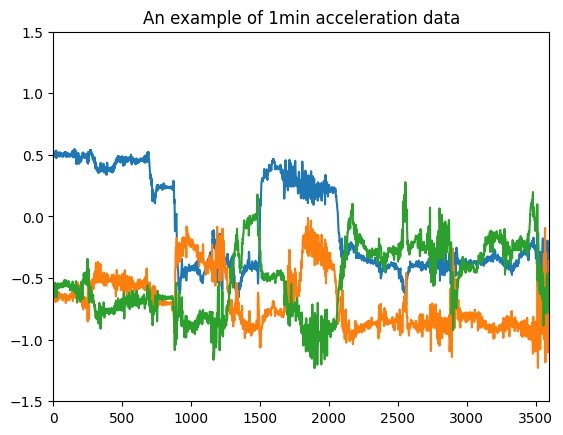

In [ ]:
plt.plot(myX)
plt.title("An example of 1min acceleration data")
plt.axis([0,3600,-1.5,1.5])

Jittering

Hyperparameters : sigma = standard devitation (STD) of the noise

In [ ]:
sigma = 0.05

In [ ]:
def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise

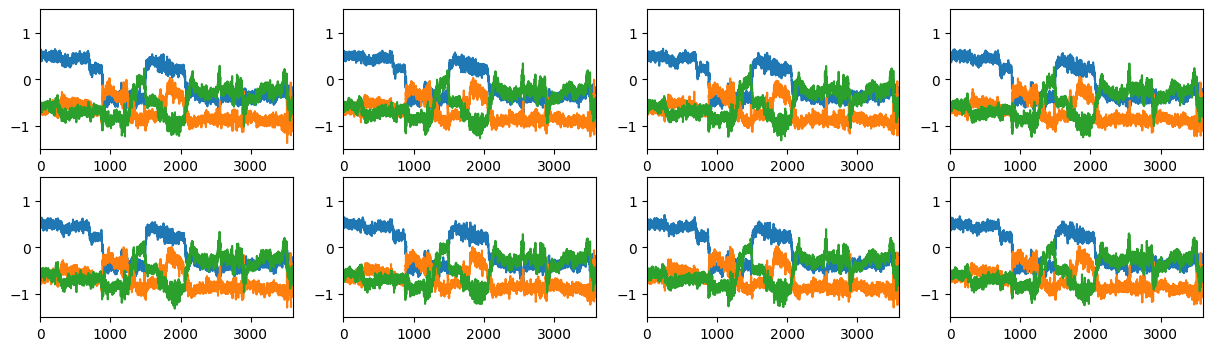

In [ ]:
fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DA_Jitter(myX, sigma))
    ax.set_xlim([0,3600])
    ax.set_ylim([-1.5,1.5])

Scaling

Hyperparameters : sigma = STD of the zoom-in/out factor

In [ ]:
sigma = 0.1

In [ ]:
def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

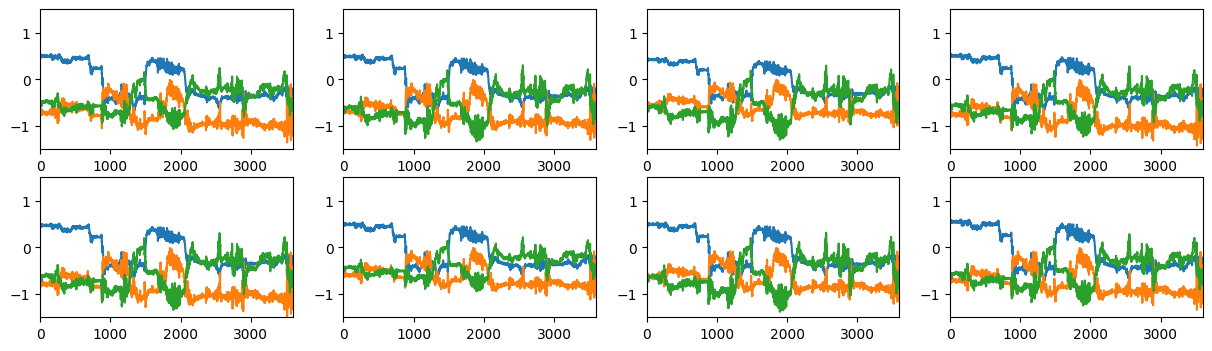

In [ ]:
fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DA_Scaling(myX, sigma))
    ax.set_xlim([0,3600])
    ax.set_ylim([-1.5,1.5])

Magnitude Warping

Hyperparameters : sigma = STD of the random knots for generating curves
knot = # of knots for the random curves (complexity of the curves)
"Scaling" can be considered as "applying constant noise to the entire samples" whereas "Jittering" can be considered as "applying different noise to each sample".

"Magnitude Warping" can be considered as "applying smoothly-varing noise to the entire samples"

In [ ]:
sigma = 0.2
knot = 4

In [ ]:
## This example using cubic splice is not the best approach to generate random curves. 
## You can use other aprroaches, e.g., Gaussian process regression, Bezier curve, etc.
def GenerateRandomCurves(X, sigma=0.2, knot=4):
    xx = (np.ones((X.shape[1],1))*(np.arange(0,X.shape[0], (X.shape[0]-1)/(knot+1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    cs_x = CubicSpline(xx[:,0], yy[:,0])
    cs_y = CubicSpline(xx[:,1], yy[:,1])
    cs_z = CubicSpline(xx[:,2], yy[:,2])
    return np.array([cs_x(x_range),cs_y(x_range),cs_z(x_range)]).transpose()

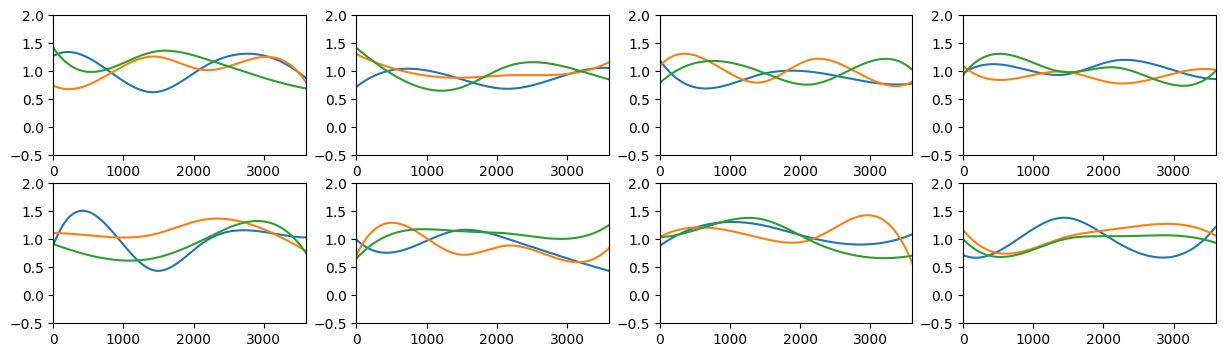

In [ ]:
## Random curves around 1.0
fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(GenerateRandomCurves(myX, sigma))
    plt.axis([0,3600,-0.5,2])

In [ ]:
def DA_MagWarp(X, sigma):
    return X * GenerateRandomCurves(X, sigma)

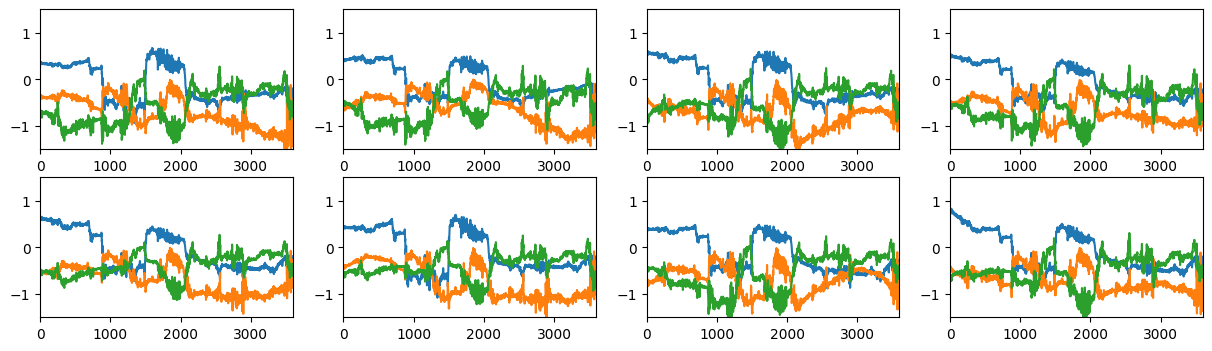

In [ ]:
fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DA_MagWarp(myX, sigma))
    ax.set_xlim([0,3600])
    ax.set_ylim([-1.5,1.5])

Time Warping

Hyperparameters : sigma = STD of the random knots for generating curves
knot = # of knots for the random curves (complexity of the curves)

In [ ]:
sigma = 0.2
knot = 4

In [ ]:
def DistortTimesteps(X, sigma=0.2):
    tt = GenerateRandomCurves(X, sigma) # Regard these samples aroun 1 as time intervals
    tt_cum = np.cumsum(tt, axis=0)        # Add intervals to make a cumulative graph
    # Make the last value to have X.shape[0]
    t_scale = [(X.shape[0]-1)/tt_cum[-1,0],(X.shape[0]-1)/tt_cum[-1,1],(X.shape[0]-1)/tt_cum[-1,2]]
    tt_cum[:,0] = tt_cum[:,0]*t_scale[0]
    tt_cum[:,1] = tt_cum[:,1]*t_scale[1]
    tt_cum[:,2] = tt_cum[:,2]*t_scale[2]
    return tt_cum

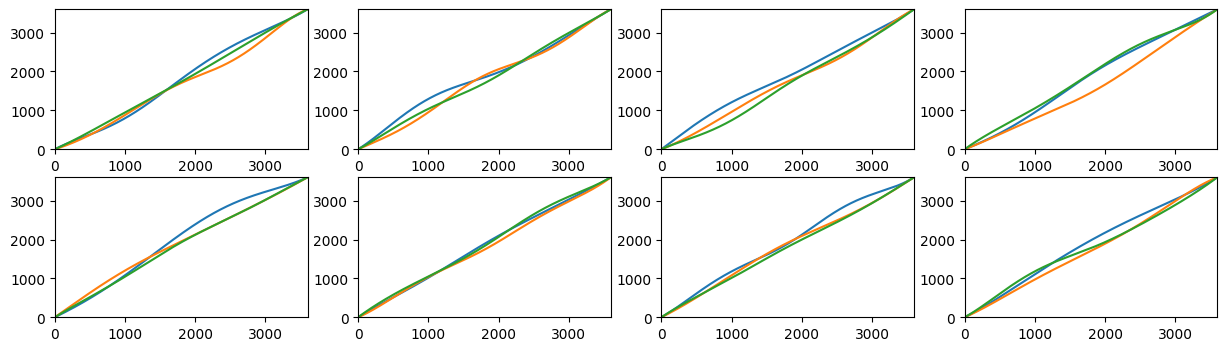

In [ ]:
## Random curves around 1.0
fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DistortTimesteps(myX, sigma))
    ax.set_xlim([0,3600])
    ax.set_ylim([0,3600])

In [ ]:
def DA_TimeWarp(X, sigma=0.2):
    tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    X_new[:,0] = np.interp(x_range, tt_new[:,0], X[:,0])
    X_new[:,1] = np.interp(x_range, tt_new[:,1], X[:,1])
    X_new[:,2] = np.interp(x_range, tt_new[:,2], X[:,2])
    return X_new

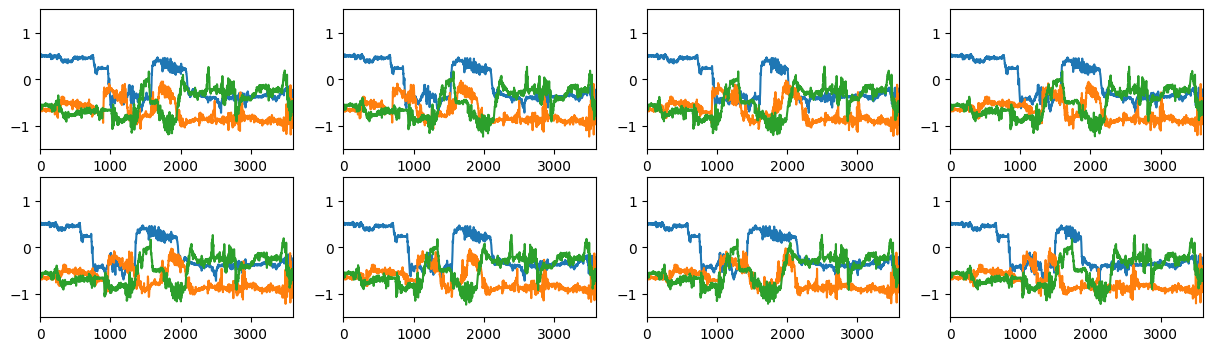

In [ ]:
fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DA_TimeWarp(myX, sigma))
    ax.set_xlim([0,3600])
    ax.set_ylim([-1.5,1.5])

Rotation

Hyperparameters : N/A

In [ ]:
def DA_Rotation(X):
    axis = np.random.uniform(low=-1, high=1, size=X.shape[1])
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    return np.matmul(X , axangle2mat(axis,angle))
fig = plt.figure(figsize=(15,4))

<Figure size 1500x400 with 0 Axes>

In [ ]:

for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DA_Rotation(myX))
    ax.set_xlim([0,3600])
    ax.set_ylim([-1.5,1.5])

Permutation

Hyperparameters : nPerm = # of segments to permute
minSegLength = allowable minimum length for each segment

In [ ]:
nPerm = 4
minSegLength = 100

In [ ]:
def DA_Permutation(X, nPerm=4, minSegLength=10):
    X_new = np.zeros(X.shape)
    idx = np.random.permutation(nPerm)
    bWhile = True
    while bWhile == True:
        segs = np.zeros(nPerm+1, dtype=int)
        segs[1:-1] = np.sort(np.random.randint(minSegLength, X.shape[0]-minSegLength, nPerm-1))
        segs[-1] = X.shape[0]
        if np.min(segs[1:]-segs[0:-1]) > minSegLength:
            bWhile = False
    pp = 0
    for ii in range(nPerm):
        x_temp = X[segs[idx[ii]]:segs[idx[ii]+1],:]
        X_new[pp:pp+len(x_temp),:] = x_temp
        pp += len(x_temp)
    return(X_new)

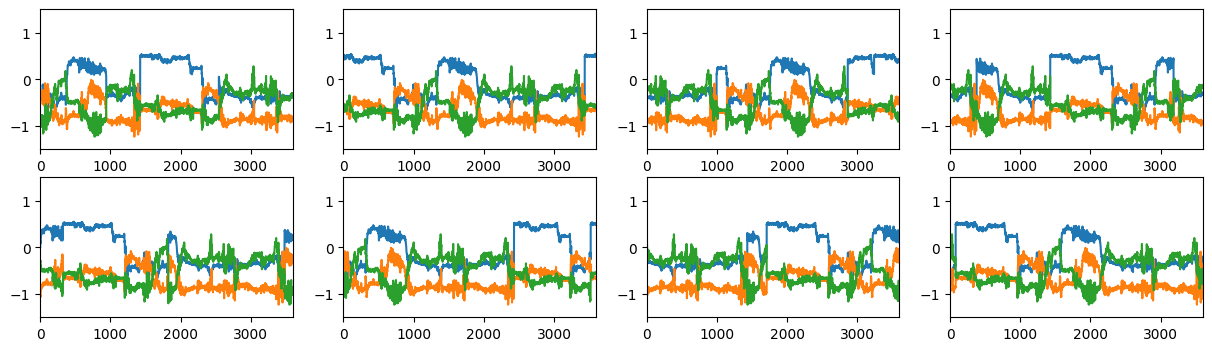

In [ ]:
fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DA_Permutation(myX))
    ax.set_xlim([0,3600])
    ax.set_ylim([-1.5,1.5])

Random Sampling

Hyperparameters : nSample = # of subsamples (nSample <= X.shape[0])

In [ ]:

nSample = 1000

In [ ]:
def RandSampleTimesteps(X, nSample=1000):
    X_new = np.zeros(X.shape)
    tt = np.zeros((nSample,X.shape[1]), dtype=int)
    tt[1:-1,0] = np.sort(np.random.randint(1,X.shape[0]-1,nSample-2))
    tt[1:-1,1] = np.sort(np.random.randint(1,X.shape[0]-1,nSample-2))
    tt[1:-1,2] = np.sort(np.random.randint(1,X.shape[0]-1,nSample-2))
    tt[-1,:] = X.shape[0]-1
    return tt

In [ ]:
def DA_RandSampling(X, nSample=1000):
    tt = RandSampleTimesteps(X, nSample)
    X_new = np.zeros(X.shape)
    X_new[:,0] = np.interp(np.arange(X.shape[0]), tt[:,0], X[tt[:,0],0])
    X_new[:,1] = np.interp(np.arange(X.shape[0]), tt[:,1], X[tt[:,1],1])
    X_new[:,2] = np.interp(np.arange(X.shape[0]), tt[:,2], X[tt[:,2],2])
    return X_new

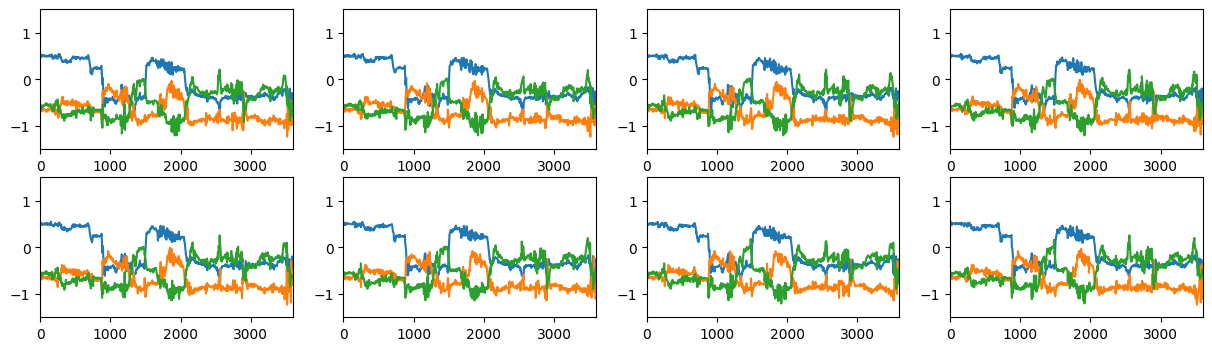

In [ ]:
fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DA_RandSampling(myX))
    ax.set_xlim([0,3600])
    ax.set_ylim([-1.5,1.5])

Combinations

You can combine any of the above data augmentation techiniques. For example,

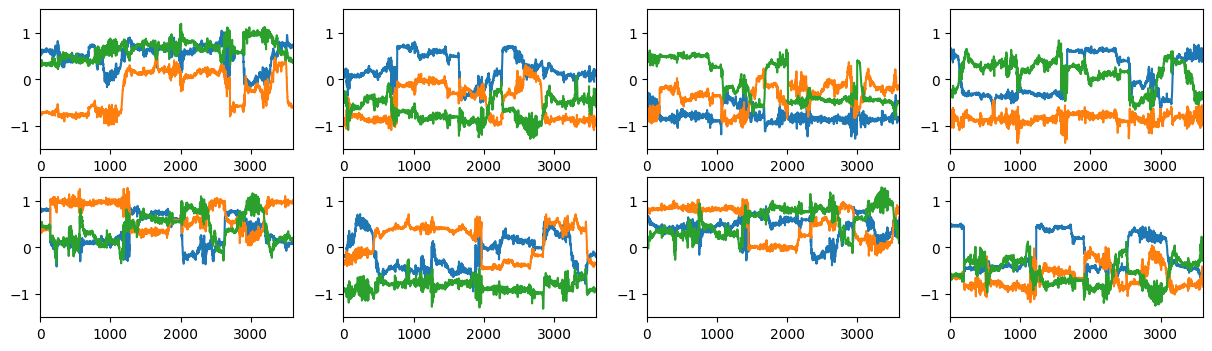

In [ ]:
## Rotation + Permutation
fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DA_Rotation(DA_Permutation(myX, nPerm=4)))
    ax.set_xlim([0,3600])
    ax.set_ylim([-1.5,1.5])